# DSP Project: Receiver using ADALM-PLUTO SDR


## 1. Filter Design Method and Order Estimation
We use the **Kaiser window method** to design a digital low-pass FIR filter on the receiver side.

### Justification:
- Kaiser window allows control over both stopband attenuation and transition width.
- Well-supported in `scipy.signal`
- FIR filters with Kaiser windows have linear phase response (important for symbol timing)

### Specifications:
- Cutoff Frequency = 10 kHz
- Stopband Frequency = 25 kHz
- Stopband Attenuation = 60 dB
- Sampling Rate = 50 kHz

### Filter Order Estimation:
We use the following Kaiser window formula:
N = (Atten - 8)/(2.285 x Delta omega) 
Where:
-  A = 60  dB 
-  Delta f = 25k - 10k = 15kHz 
-  Delta omega = (Delta f)/(f_s/2) = 0.6 

Final estimated filter order: **≈ 38**, rounded to **39** (odd for symmetry).


Kaiser-windowed FIR filter is designed using the estimated parameters. The output is a set of coefficients representing the impulse response of the filter.

In [2]:

from scipy.signal import firwin, kaiserord
import numpy as np

fs = 50000
cutoff_freq = 10000
stopband_freq = 25000
atten = 60

nyq = fs / 2
width = (stopband_freq - cutoff_freq) / nyq

N = 39
kaiser_filter = firwin(N, cutoff_freq/nyq, window=('kaiser', beta))

print(f"Estimated filter order: {N}, Beta: {beta:.2f}")
print("Filter Coefficients:", kaiser_filter)


Estimated filter order: 39, Beta: 5.65
Filter Coefficients: [-3.24857835e-04 -4.24408645e-04  7.52331216e-04  1.95906587e-03
 -2.28702573e-18 -4.27543201e-03 -3.68856445e-03  5.01441586e-03
  1.08032082e-02 -7.29106501e-18 -1.83309506e-02 -1.45614944e-02
  1.86661860e-02  3.88467292e-02 -1.30207749e-17 -6.74821209e-02
 -5.84872504e-02  9.09268862e-02  3.00598951e-01  4.00014611e-01
  3.00598951e-01  9.09268862e-02 -5.84872504e-02 -6.74821209e-02
 -1.30207749e-17  3.88467292e-02  1.86661860e-02 -1.45614944e-02
 -1.83309506e-02 -7.29106501e-18  1.08032082e-02  5.01441586e-03
 -3.68856445e-03 -4.27543201e-03 -2.28702573e-18  1.95906587e-03
  7.52331216e-04 -4.24408645e-04 -3.24857835e-04]


## 2. Frequency Response with Ideal Coefficients
We plot the magnitude and phase response of the ideal FIR filter (non-quantized) to analyze its behavior in frequency domain.

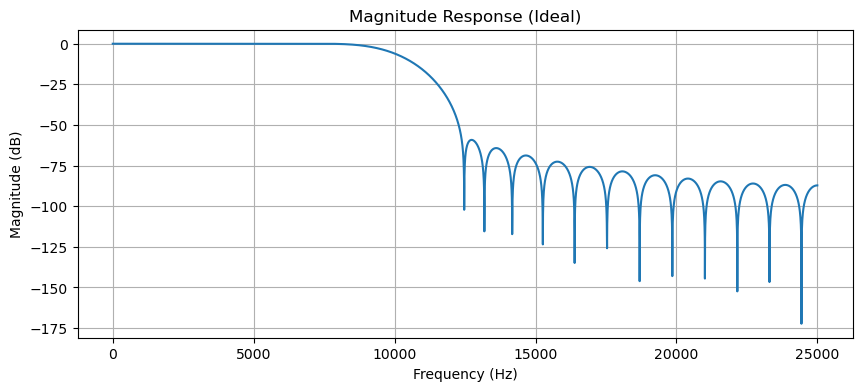

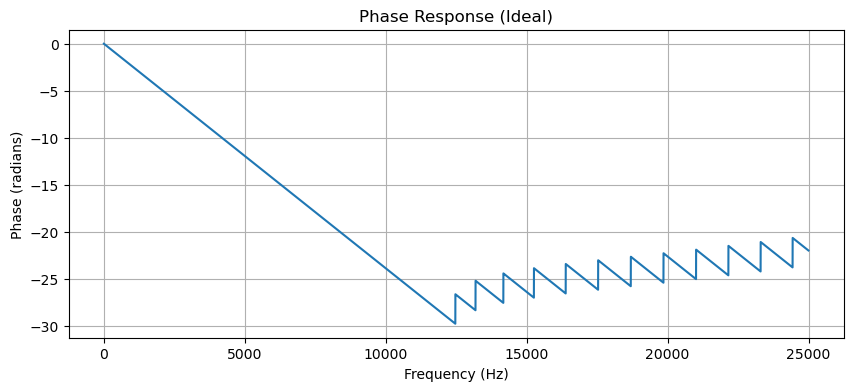

In [3]:

from scipy.signal import freqz
import matplotlib.pyplot as plt

w, h = freqz(kaiser_filter, worN=8000)
freqs = w * nyq / np.pi

plt.figure(figsize=(10, 4))
plt.plot(freqs, 20 * np.log10(abs(h)))
plt.title("Magnitude Response (Ideal)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(freqs, np.unwrap(np.angle(h)))
plt.title("Phase Response (Ideal)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (radians)")
plt.grid(True)
plt.show()


## 3 Frequency Response with Quantized Coefficients
Quantize the filter coefficients to **8-bit** resolution. This means scaling them to range \([-127, +127]\), rounding, and scaling back.

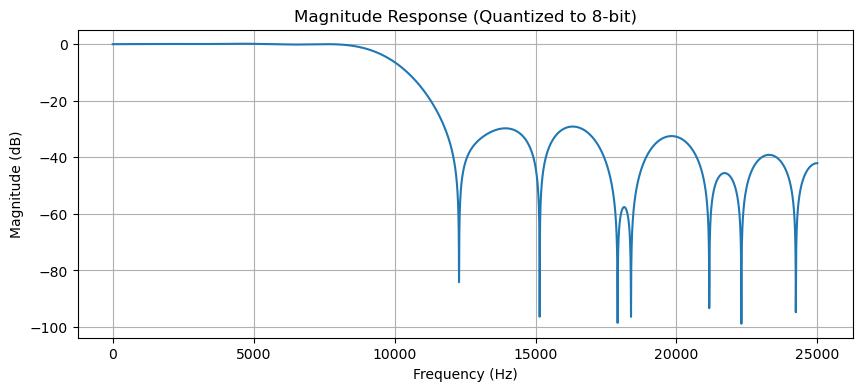

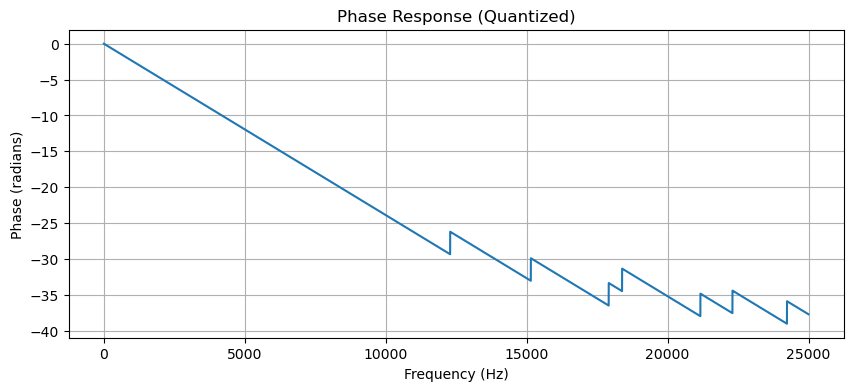

In [4]:

quant_bits = 8
scale = 2**(quant_bits - 1) - 1
quantized_filter = np.round(kaiser_filter * scale) / scale

wq, hq = freqz(quantized_filter, worN=8000)

plt.figure(figsize=(10, 4))
plt.plot(freqs, 20 * np.log10(np.abs(hq)))
plt.title("Magnitude Response (Quantized to 8-bit)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(freqs, np.unwrap(np.angle(hq)))
plt.title("Phase Response (Quantized)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (radians)")
plt.grid(True)
plt.show()


## 4. PlutoSDR Receiver Configuration
Configure the ADALM-PLUTO SDR to:
- Tune to 169 MHz center frequency
- Use a 2 MHz RF bandwidth
- Sample at 50 kHz

Collect samples from the air using the `adi` library.

In [5]:

from adi import pluto
sdr = pluto.Pluto()
sdr.sample_rate = int(fs)
sdr.rx_rf_bandwidth = 2000000
sdr.rx_lo = int(169e6)          #Fc Sewt at 169MHz
sdr.rx_buffer_size = 8192
rx_samples = sdr.rx()


D:\Programming_Softwares\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
D:\Programming_Softwares\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
D:\Programming_Softwares\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


ImportError: cannot import name 'pluto' from 'adi' (D:\Programming_Softwares\anaconda3\Lib\site-packages\adi\__init__.py)

## 5. Frequency Domain Analysis of Received Signal
We apply the quantized filter to the received signal and compare the FFT spectrum **before and after filtering** to confirm noise suppression and signal integrity.

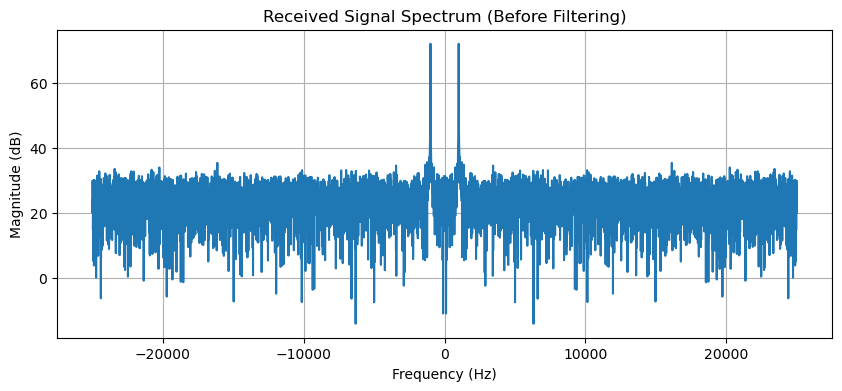

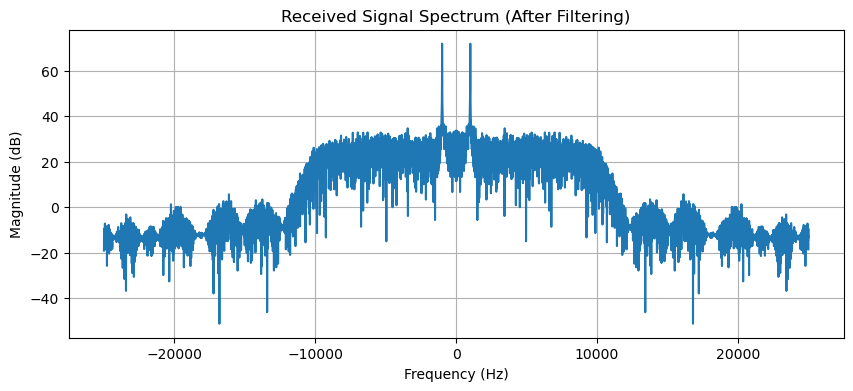

In [7]:

from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import lfilter

# Random data if SDR unavailable
#rx_samples = np.random.randn(8192) * 0.2 + np.sin(2*np.pi*1e3*np.arange(8192)/fs)

# Filter the received samples
filtered_signal = lfilter(quantized_filter, 1.0, rx_samples)

# FFT before filtering
fft_before = fft(rx_samples)
freq = fftfreq(len(fft_before), 1/fs)

plt.figure(figsize=(10, 4))
plt.plot(fftshift(freq), 20*np.log10(np.abs(fftshift(fft_before)) + 1e-6))
plt.title("Received Signal Spectrum (Before Filtering)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.show()

# FFT after filtering
fft_after = fft(filtered_signal)

plt.figure(figsize=(10, 4))
plt.plot(fftshift(freq), 20*np.log10(np.abs(fftshift(fft_after)) + 1e-6))
plt.title("Received Signal Spectrum (After Filtering)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.show()
